In [1]:
!pip install transformers
!pip install bert-tensorflow 
!pip install pyenchant
!pip install -U pip setuptools wheel
!pip install -U spacy
!sudo apt-get install libenchant1c2a
!python -m spacy download en_core_web_sm
!pip install pandas
!pip install sklearn
!pip install seaborn
!pip install nltk
!pip install torchvision 
!pip install keras
!pip3 install torch torchvision
!pip install tensorflow
!pip install tensorflow_hub

     |████████████████████████████████| 2.6 MB 3.0 MB/s eta 0:00:01
  Using cached huggingface_hub-0.0.12-py3-none-any.whl (37 kB)
  Using cached filelock-3.0.12-py3-none-any.whl (7.6 kB)
  Using cached tokenizers-0.10.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Using cached regex-2021.7.6-cp37-cp37m-manylinux2014_x86_64.whl (721 kB)
  Using cached sacremoses-0.0.45-py3-none-any.whl (895 kB)
  Using cached bert_tensorflow-1.0.4-py2.py3-none-any.whl (64 kB)
  Using cached pyenchant-3.2.1-py3-none-any.whl (55 kB)
     |████████████████████████████████| 1.6 MB 2.9 MB/s eta 0:00:01
  Using cached setuptools-57.4.0-py3-none-any.whl (819 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.6.0.post20210108
    Uninstalling setuptools-49.6.0.post20210108:
      Successfully uninstalled setuptools-49.6.0.post20210108
  Attempting uninstall: pip
    Found existing installation: pip 21.1.2
    Unin

In [13]:
# import package

import warnings
warnings.filterwarnings('ignore')

import numpy as np 
from numpy import asarray
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer

import re
import time
import torch

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
import transformers as ppb

from nltk.corpus import stopwords
import nltk.tokenize as tk
import torch
import torch.nn as nn
import transformers
from transformers import BertTokenizer, AdamW, BertModel, AutoModel, BertTokenizerFast,BertForSequenceClassification

# Keras functional API
from keras.models import Sequential, Model, load_model, model_from_config
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Flatten, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import os
import csv
import copy

import tensorflow as tf
import tensorflow_hub as hub

# import enchant #  Enchant spellchecking library
import spacy
import re
import urllib.request
#from bs4 import BeautifulSoup

# xgboost
!pip install xgboost
import xgboost
from xgboost import XGBRegressor

In [4]:
train = pd.read_csv("training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1')
dev = pd.read_csv("valid_set.tsv",sep='\t', encoding='ISO-8859-1')
test = pd.read_csv("test_set.tsv",sep='\t', encoding='ISO-8859-1')

In [5]:
def preprocess(df):
    df['normalized_score'] = df['domain1_score'] / df.groupby('essay_set')['domain1_score'].transform('max')

preprocess(train)

In [6]:
def clean_anonymization(essay):
    res=[]
    # Lowercase
    essay = essay.lower()
    # Remove single letter words
    essay = ' '.join( [w for w in essay.split() if len(w)>1] )
    for i in essay.split():
        if i.startswith("@"):
            continue
        else:
            res.append(i)
    return ' '.join(res)

train['essay']=train['essay'].apply(lambda x:clean_anonymization(x))
# also remove from dev and test
dev['essay']=dev['essay'].apply(lambda x:clean_anonymization(x))
test['essay']=test['essay'].apply(lambda x:clean_anonymization(x))

In [7]:
test.head()

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,believe that computers have positive effect on...,2383,NaN
1,2384,1,dear caps know some problems have came up wher...,2384,NaN
2,2385,1,dear to whom it month concern computers aren't...,2385,NaN
3,2386,1,dear caps caps caps has come to my attention t...,2386,NaN
4,2387,1,dear local newspaper think that people have la...,2387,NaN


In [8]:
X = train[['essay']]
y = train['normalized_score']

In [9]:
y.head()

0    0.666667
1    0.750000
2    0.583333
3    0.833333
4    0.666667
Name: normalized_score, dtype: float64

In [10]:
# Load pre-trained model (weights)
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def lstm_model():
    """
    Define the model
    """
    Hidden_dim1=300
    Hidden_dim2=64
    dropout= 0.5
    recurrent_dropout=0.4
    
    model = Sequential()
    model.add(LSTM(Hidden_dim1, dropout=dropout, recurrent_dropout=recurrent_dropout, input_shape=[1,768], return_sequences= True))
    model.add(LSTM(Hidden_dim2, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='relu'))
    
    #optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    model.summary()

    return model

In [12]:
def accuracy_graph(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['mae'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Fold 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            1282800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,376,305
Trainable params: 1,376,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
325/325 [==============================] - 20s 4ms/step - loss: 0.0565 - mae: 0.1824
Epoch 2/20
325/325 [==============================] - 1s 4ms/step - loss: 0.0320 - mae: 0.1413
Epoch 3/20
325/325 [==========================

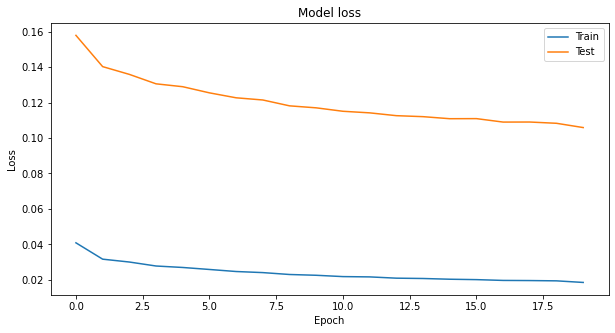

MSE for training set: 0.015606652177823272
MSE for test set: 0.021823048873962216
Fold 2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            1282800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,376,305
Trainable params: 1,376,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
325/325 [==============================] - 6s 4ms/step - loss: 0.0554 - mae: 0.1795
Epoch 2/20
325/325 [==============================] - 1s 4ms

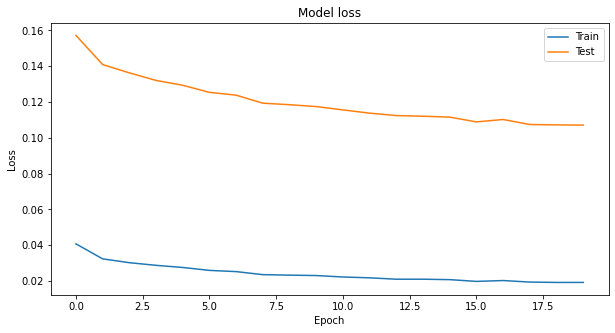

MSE for training set: 0.01501297155427354
MSE for test set: 0.020781513882343932
Fold 3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            1282800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,376,305
Trainable params: 1,376,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
325/325 [==============================] - 6s 4ms/step - loss: 0.0560 - mae: 0.1833
Epoch 2/20
325/325 [==============================] - 1s 4ms/

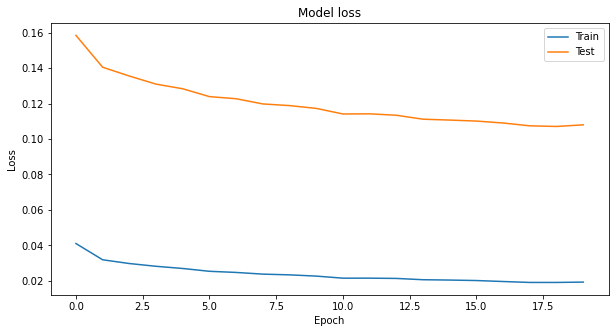

MSE for training set: 0.015494010272803562
MSE for test set: 0.021064881201764477
Fold 4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            1282800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,376,305
Trainable params: 1,376,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
325/325 [==============================] - 6s 4ms/step - loss: 0.0565 - mae: 0.1816
Epoch 2/20
325/325 [==============================] - 1s 4ms

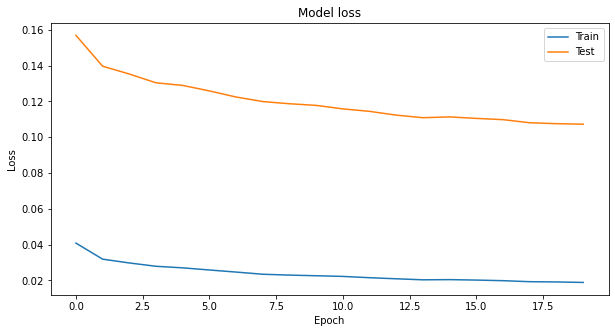

MSE for training set: 0.015471179908961042
MSE for test set: 0.021440661744862786
Fold 5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            1282800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,376,305
Trainable params: 1,376,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
325/325 [==============================] - 7s 4ms/step - loss: 0.0560 - mae: 0.1794
Epoch 2/20
325/325 [==============================] - 1s 4ms

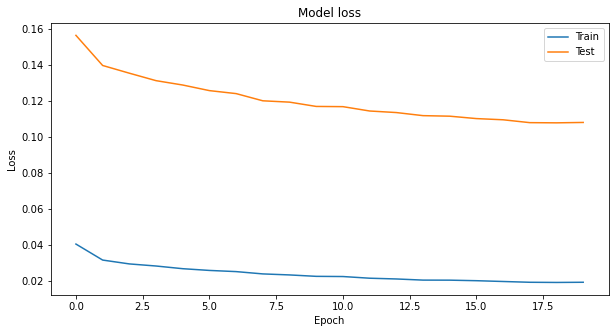

MSE for training set: 0.016185426860499685
MSE for test set: 0.021953764797388788


In [15]:
# epoch of 20

total_train_loss = []
total_test_loss = []
total_train_acc = []
total_test_acc = []
results = []

# prediction_list = []

cv = KFold(n_splits=5, shuffle=True)
cv_data = cv.split(X)

fold_cnt =1
cuda = torch.device('cuda')

with torch.cuda.device(cuda):
    for traincv, testcv in cv_data:
        torch.cuda.empty_cache()
        print("Fold {}".format(fold_cnt))
        
        # get the train and test from the dataset.
        X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
        train_essays = X_train['essay']
        test_essays = X_test['essay']
        
        tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, 
                                                                     add_special_tokens=True,
                                                                     max_length=200)))
        tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=200)))
        
        # input_id for train dataset
        max_len = 0
        for i in tokenized_train.values:
            if len(i) > max_len:
                max_len = len(i)
        padded_train = np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])
        
        attention_mask_train = np.where(padded_train != 0, 1, 0)
        train_input_ids = torch.tensor(padded_train)
        train_attention_mask = torch.tensor(attention_mask_train)
        
        with torch.no_grad():
            outputs_train = bert_model(train_input_ids, attention_mask=train_attention_mask)
            last_hidden_states_train = outputs_train[0]  # get the last hidden state
        train_features = last_hidden_states_train[:,0,:].numpy()
        
        ## input_id for test dataset
        max_len = 0
        for i in tokenized_test.values:
            if len(i) > max_len:
                max_len = len(i)
        padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
        
        attention_mask_test = np.where(padded_test != 0, 1, 0)
        test_input_ids = torch.tensor(padded_test)  
        test_attention_mask = torch.tensor(attention_mask_test)
        
        with torch.no_grad():
            outputs_test  = bert_model(test_input_ids, attention_mask=test_attention_mask)
            last_hidden_states_test = outputs_test[0]  # get the last hidden state
        test_features = last_hidden_states_test[:,0,:].numpy()
        
        #shape to fit the layer
        train_x,train_y = train_features.shape
        test_x,test_y = test_features.shape
        x_train_reshaped = np.reshape(train_features,(train_x,1,train_y))
        x_test_reshaped = np.reshape(test_features,(test_x,1,test_y))
        
        lstm = lstm_model()
        # plot the loss and metric
        history = lstm.fit(x_train_reshaped, y_train, batch_size=32, epochs=20)
        accuracy_graph(history)
        
        y_pred_train = lstm.predict(x_train_reshaped)
        y_pred_test = lstm.predict(x_test_reshaped)
        
        # evaluate the model
        train_loss = mean_squared_error(y_train.values,y_pred_train)
        test_loss = mean_squared_error(y_test.values,y_pred_test)
        train_acc = mean_absolute_error(y_train.values,y_pred_train)
        test_acc = mean_absolute_error(y_train.values,y_pred_train)
        print("MSE for training set: {}".format(train_loss))
        print("MSE for test set: {}".format(test_loss))
        total_train_loss.append(train_loss)
        total_test_loss.append(test_loss)
        total_train_acc.append(train_acc)
        total_test_acc.append(test_acc)
        
        fold_cnt +=1
        tf.keras.backend.clear_session()

In [15]:
# save model and architecture to single file
lstm.save("lstm_model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
# load model
lstm_model = load_model('lstm_model.h5')
# summarize model
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 300)            1282800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,376,305
Trainable params: 1,376,305
Non-trainable params: 0
_________________________________________________________________


## getting the semantic score 

In [17]:
def semantic_score(df):
    tokenized_essay = df.essay.apply((lambda x: tokenizer.encode(x, add_special_tokens=True,max_length=200)))
    max_len = 0
    for i in tokenized_essay.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized_essay.values])
    attention_mask = np.where(padded != 0, 1, 0)
    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)
    
    with torch.no_grad():
        outputs  = bert_model(input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs[0]  # get the last hidden state
    features = last_hidden_states[:,0,:].numpy()
    
    x_shape, y_shape = features.shape
    x_reshaped = np.reshape(features,(x_shape,1,y_shape))
    semantic_score = lstm_model.predict(x_reshaped)
    return semantic_score

In [18]:
semantic_score_train = semantic_score(train)

In [19]:
semantic_score_train = pd.DataFrame(semantic_score_train.tolist())
semantic_score_train.columns = ['semantic_score']

In [20]:
semantic_score_train.to_csv('semantic_score_train.csv')

In [ ]:
mean_squared_error(y_test.values,semantic_score_train)

In [26]:
# getting the semantic score for test 
semantic_score_test = semantic_score(test)

In [28]:
semantic_score_test = pd.DataFrame(semantic_score_test.tolist())

In [30]:
semantic_score_test.to_csv('semantic_score_test.csv')

In [31]:
# getting the semantic score for dev
semantic_score_dev = semantic_score(dev)

In [33]:
semantic_score_dev = pd.DataFrame(semantic_score_dev.tolist())
semantic_score_dev.columns = ['semantic_score']

In [35]:
semantic_score_dev.to_csv('semantic_score_dev.csv')

In [13]:
test = pd.read_csv('semantic_score_train.csv')

In [27]:
y_pred = semantic_score_train['semantic_score']

In [28]:
mean_squared_error(y.values,y_pred)

0.021648709013453428